In [1]:
import numpy as np
import matplotlib.pyplot as plt

spikes_obs = np.load('/hpc/mzhu843/modelling/nest/notebooks/optimization/simulated_annealing/model2/sensitivity_analysis results/2024-05-14 15:33:38/{\'weights_range\': (-20, 20), \'weights_change_range\': (-4, 4), \'input_weights_range\': (-40, 40), \'input_weights_change_range\': (-5, 5), \'input_weights_prob\': 0.05}/Run 1 Best Predicted Spikes.npy')
plt.plot(spikes_obs[0])





FileNotFoundError: [Errno 2] No such file or directory: "/hpc/mzhu843/modelling/nest/notebooks/optimization/simulated_annealing/model2/sensitivity_analysis results/2024-05-14 15:33:38/{'weights_range': (-20, 20), 'weights_change_range': (-4, 4), 'input_weights_range': (-40, 40), 'input_weights_change_range': (-5, 5), 'input_weights_prob': 0.05}/Run 1 Best Predicted Spikes.npy"

In [ ]:
import numpy as np
weights1 = np.load('/hpc/mzhu843/modelling/nest/notebooks/optimization/simulated_annealing/model2/sensitivity_analysis results/Setup1/2024-04-29 18:21:26/2024-04-29 18:30:06/weights1.npy')
weights2 = np.load('/hpc/mzhu843/modelling/nest/notebooks/optimization/simulated_annealing/model2/sensitivity_analysis results/Setup1/2024-04-29 18:21:26/2024-04-29 18:30:06/weights2.npy')

print(weights1[:5, :5])
print(weights2[:5, :5])



[[ 0.  18.6 14.6 11.5 19.4]
 [13.5  0.  13.8 16.4 18.6]
 [-4.7 -5.3  0.  -3.2 -9.2]
 [13.5 13.4 16.4  0.  18.4]
 [13.3 16.5 11.1 12.4  0. ]]
[[ -5.8   8.5   7.3 -10.4   5.9]
 [  2.4 -14.3  -2.3   6.9  12.6]
 [ -4.1   4.2   3.9   4.7  -5.3]
 [ 12.4  11.1  -5.1  -5.7   7.7]
 [  2.5   5.7   7.3  -6.5  12.1]]


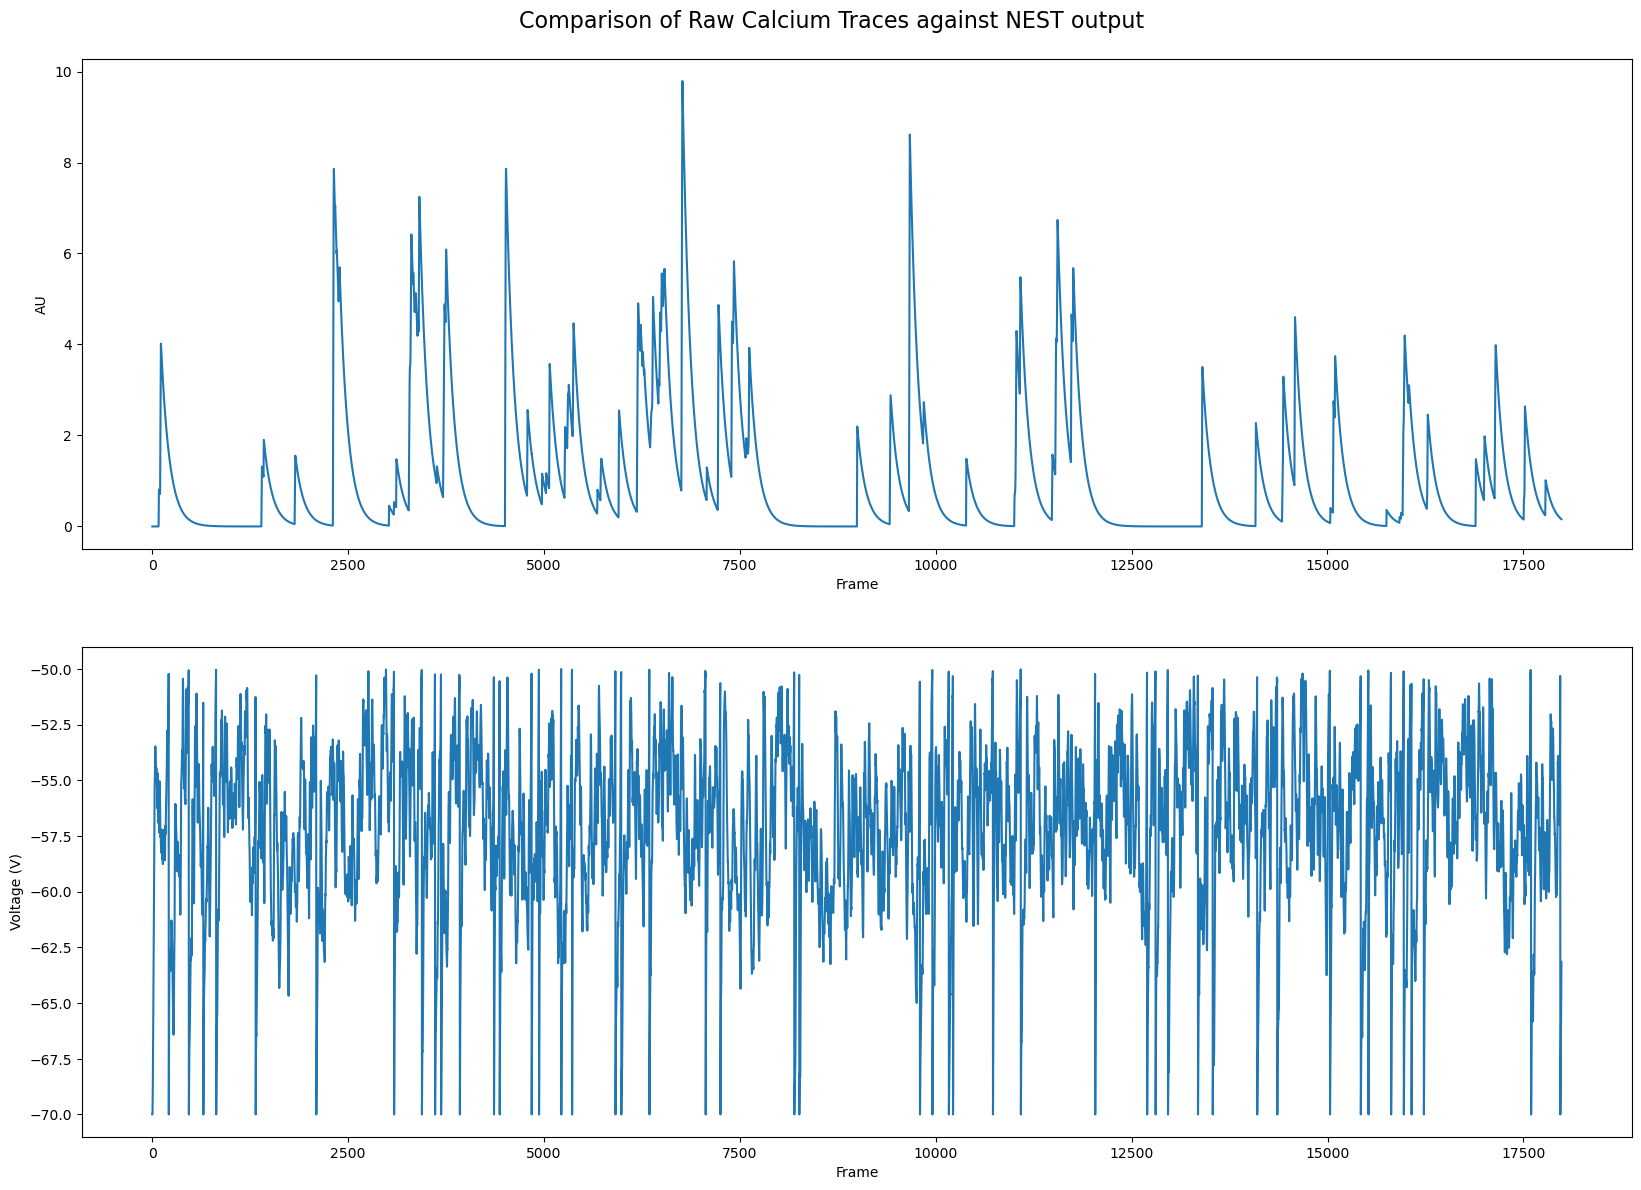

In [ ]:
import numpy as np
import nest
import matplotlib.pyplot as plt

from params import pyr_hcamp_deco2012
from scripts import visualizations

calcium_trace_1 = np.load('/hpc/mzhu843/modelling/nest/DATA/raw/calcium traces/C_3.npy')[83]

pyr = nest.Create('iaf_psc_alpha', n=1, params=pyr_hcamp_deco2012.params)
external_input = nest.Create('poisson_generator', n=10)
external_input.set(rate=40)

external_parrot = nest.Create('parrot_neuron', n=1)

nest.Connect(external_input, external_parrot)
nest.Connect(external_parrot, pyr, syn_spec={'weight': 90})

Vm_recorder = nest.Create('multimeter')
Vm_recorder.set(record_from=['V_m'])
nest.Connect(Vm_recorder, pyr)

spike_recorder = nest.Create('spike_recorder')
nest.Connect(pyr, spike_recorder)

nest.Simulate(17988)

ts = Vm_recorder.get('events')['times']
vms = Vm_recorder.get('events')['V_m']
fig, axs = plt.subplots(2, 1, figsize=(20, 14))
axs[0].plot(calcium_trace_1)
axs[0].set_ylabel('AU')
axs[0].set_xlabel('Frame')


axs[1].plot(vms)
axs[1].set_ylabel('Voltage (V)')
axs[1].set_xlabel('Frame')

fig.suptitle('Comparison of Raw Calcium Traces against NEST output', y=0.915, fontsize = 16)
plt.savefig('/hpc/mzhu843/modelling/nest/plots/raw_vs_simulation.png')





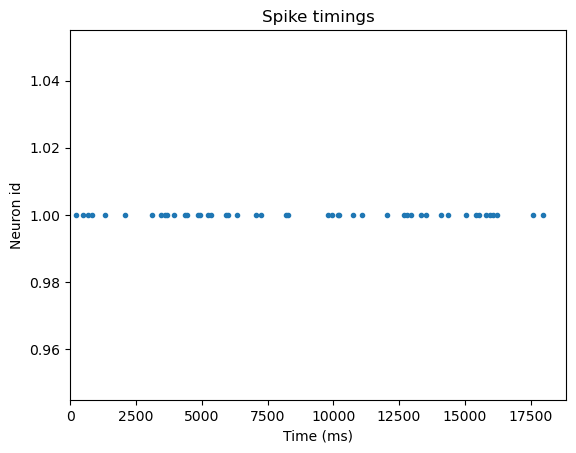

In [ ]:
visualizations.plot_spikes_from_device(spike_recorder) 

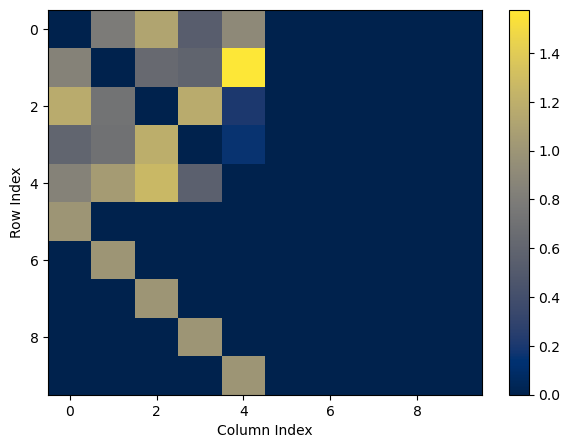

In [ ]:
import numpy as np
from scripts import visualizations

matrix = np.load('/hpc/mzhu843/modelling/nest/DATA/raw/inital_matrices/model2/initial_weights.npy')
visualizations.plot_matrix(matrix)

In [ ]:
from scripts import optimization, model
import numpy as np
import pickle

first_weights = np.zeros((10, 10))

for i in range(5):
    first_weights[i][0:5] = np.random.normal(1, scale=0.4, size=5)
    first_weights[i + 5][i] = 1

for i in range(10):
    first_weights[i][i] = 0


first_input_weights = np.random.normal(2.5, scale=3, size=(5, 3000))

with open('/hpc/mzhu843/modelling/nest/DATA/processed/model2/categorized_neurons.pkl', 'rb') as file:
    # Load the object from the file
    small_categorized_neurons = pickle.load(file)

network = model.Model2(small_categorized_neurons, first_input_weights, first_weights)

network.simulate()

place_obs = network.get_voltage_traces()

second_weights = np.zeros((10, 10))

for i in range(5):
    second_weights[i][0:5] = np.random.randint(-3, 3, size=5)
    second_weights[i + 5][i] = 1

for i in range(10):
    second_weights[i][i] = 0

second_input_weights = np.random.normal(2.5, scale=3, size=(5, 3000))

move_params = {
                'weights_range': [(-5, 5), (-4, 4), (-3, 3)],
                'weights_change_range': [(-0.1, 0.1), (-0.2, 0.2), (-0.3, 0.3), (-0.4, 0.4)],
            }

lamb = 0.01

problem = optimization.SimulatedAnnealing2(second_weights, place_obs , lamb, small_categorized_neurons, first_input_weights, move_params)
problem.steps = 10

sensitivity_analysis = optimization.SensitivityAnalysis(move_params, problem, ['weights_range', 'weights_change_range'], save_results=True)
param_perms = sensitivity_analysis.generate_param_permutations()
sensitivity_analysis.run_analysis()


/home/mzhu843/miniconda3/envs/nest/lib/python3.11/site-packages/nest/lib/hl_api_nodes.py:151: UserWarning:SetStatus() call failed, but nodes have already been created! The node IDs of the new nodes are: NodeCollection(metadata=None, model=spike_generator, size=1, first=6).


NESTErrors.BadProperty: BadProperty in SLI function SetStatus_id: Setting status of a 'spike_generator' with node ID 6: spike_weights must have the same number of elements as spike_times, or 0 elements to clear the property.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

values = np.arange(-70, -50 , 0.5)
weights = (0.1 + (values - values,min()) * (0.9) / (values.max() - values.min())) ** 2

plt.plot(values)
plt.show()
plt.close()

plt.plot(weights)
plt.show()
plt.close()

TypeError: min expected at least 1 argument, got 0

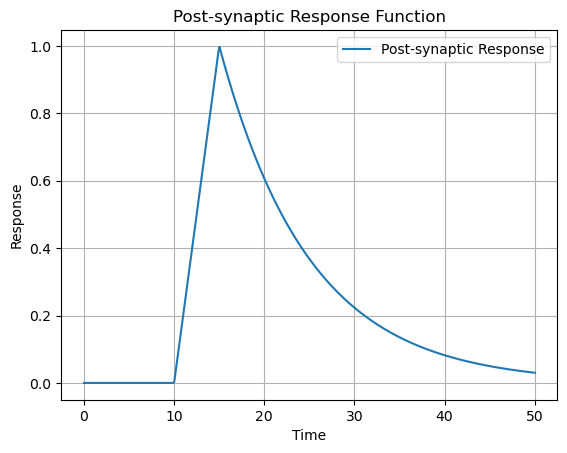

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def post_synaptic_response(t, onset_time, rise_time, amplitude, decay_tau, resting_value):
    """
    Compute the post-synaptic response function.

    Parameters:
    - t: Time array (numpy array or scalar)
    - onset_time: Time when the response starts
    - rise_time: Time duration of the rise phase
    - amplitude: Peak amplitude of the response
    - decay_tau: Time constant for the decay phase
    - resting_value: Value to which the response decays after the peak

    Returns:
    - Response values corresponding to time t
    """
    response = np.zeros_like(t)
    mask = (t >= onset_time) & (t < onset_time + rise_time)
    response[mask] = amplitude * (t[mask] - onset_time) / rise_time
    mask = (t >= onset_time + rise_time)
    response[mask] = amplitude * np.exp(-(t[mask] - (onset_time + rise_time)) / decay_tau) + resting_value
    return response

# Example usage and plot
t = np.linspace(0, 50, 500)  # Time array
response = post_synaptic_response(t, onset_time=10, rise_time=5, amplitude=1.0, decay_tau=10, resting_value=0.0)

plt.figure()
plt.plot(t, response, label='Post-synaptic Response')
plt.xlabel('Time')
plt.ylabel('Response')
plt.title('Post-synaptic Response Function')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np

total_tn = 0
total_fn = 0
total_tp = 0
total_fp = 0

for change_range in [(-30, 30), (-20, 20), (-10, 10)]:
    for change in [(-3, 3), (-2, 2), (-1, 1)]:
        path = f"/hpc/mzhu843/modelling/nest/results/optimisation/setup_3/standard_1/{{'weights_range': {change_range}, 'weights_change_range': {change}}}/"
        for run in [1,2,3]:
            true_spikes = np.load(path + 'Observed Place Spikes.npy')
            pred_spikes = np.load(path + f'Run {run} Best Predicted Place Spikes.npy')
            # true_spikes_int = np.load(path + 'Observed Int Spikes.npy')
            # pred_spikes_int = np.load(path + f'Run {run} Best Predicted Int Spikes.npy')
            cm = confusion_matrix(true_spikes.flatten(), pred_spikes.flatten())
            tn, fp, fn, tp = cm.ravel()

            total_tn += tn
            total_fn += fn
            total_tp += tp
            total_fp += fp
print('Tn',total_tn//27)
print('Fp',total_fp//27)
print('Fn',total_fn//27)
print('Tp',total_tp//27)


ValueError: Found input variables with inconsistent numbers of samples: [38961, 17982]